In [3]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata

In [5]:
# The given data encoded into vectors and matrices
attributes = np.array(["GRE", "GPA", "College ranking", "Recommendation Rating", "Interview Rating"])
candidates = np.array(["Alfred", "Beverly", "Calvin", "Diane", "Edward", "Fran"])
raw_data = np.array([
    [690, 3.1,  9,  7,  4],
    [590, 3.9,  7,  6, 10],
    [600, 3.6,  8,  8,  7],
    [620, 3.8,  7, 10,  6],
    [700, 2.8, 10,  4,  6],
    [650, 4.0,  6,  9,  8],
])

weights = np.array([0.3, 0.2, 0.2, 0.15, 0.15])

# The indices of the attributes (zero-based) that are considered beneficial.
# Those indices not mentioned are assumed to be cost attributes.
# benefit_attributes = set([0, 1, 2, 3, 4])
criteria_types = ['max', 'max', 'max', 'max', 'max']

# Display the raw data we have
pd.DataFrame(data=raw_data, index=candidates, columns=attributes)

,GRE,GPA,College ranking,Recommendation Rating,Interview Rating
Alfred,690.0,3.1,9.0,7.0,4.0
Beverly,590.0,3.9,7.0,6.0,10.0
Calvin,600.0,3.6,8.0,8.0,7.0
Diane,620.0,3.8,7.0,10.0,6.0
Edward,700.0,2.8,10.0,4.0,6.0
Fran,650.0,4.0,6.0,9.0,8.0


## Step 1 - Normalizing the ratings

$$r_{ij}=\frac{x_{ij}}{\sqrt{\sum_{i = 1}^{m} x_{ij}^2}}$$

where $i = 1, 2, \ldots, m$ and $j = 1, 2, \ldots, n$.

In [6]:
m = len(raw_data)
n = len(attributes)
divisors = np.empty(n)
for j in range(n):
    column = raw_data[:,j]
    divisors[j] = np.sqrt(column @ column)

raw_data /= divisors

columns = ["X_%d" % j for j in range(n)]
pd.DataFrame(data=raw_data, index=candidates, columns=columns)

,X_0,X_1,X_2,X_3,X_4
Alfred,0.438053,0.355454,0.462299,0.376322,0.230556
Beverly,0.374567,0.447184,0.359566,0.322562,0.576390
Calvin,0.380916,0.412785,0.410932,0.430083,0.403473
Diane,0.393613,0.435718,0.359566,0.537603,0.345834
Edward,0.444402,0.321055,0.513665,0.215041,0.345834
Fran,0.412659,0.458650,0.308199,0.483843,0.461112


## Step 2 - Calculating the Weighted Normalized Ratings

$$v_{ij} = w_j r_{ij}$$

where $i = 1, 2, \ldots, m$ and $j = 1, 2, \ldots, n$.

In [7]:
raw_data *= weights
pd.DataFrame(data=raw_data, index=candidates, columns=columns)

,X_0,X_1,X_2,X_3,X_4
Alfred,0.131416,0.071091,0.092460,0.056448,0.034583
Beverly,0.112370,0.089437,0.071913,0.048384,0.086459
Calvin,0.114275,0.082557,0.082186,0.064512,0.060521
Diane,0.118084,0.087144,0.071913,0.080640,0.051875
Edward,0.133321,0.064211,0.102733,0.032256,0.051875
Fran,0.123798,0.091730,0.061640,0.072576,0.069167


## Step 3 - Identifying PIS ($A^*$) and NIS ($A^-$)

$$
\begin{align}
A^* &= \left\{v_1^*, v_2^*, \ldots, v_n^*\right\} \\
A^- &= \left\{v_1^-, v_2^-, \ldots, v_n^-\right\} \\
\end{align}
$$

And we define

$$
\begin{align}
v_j^* &=
\begin{cases}
\max{(v_{ij})}, \text{ if} j \in J_1 \\
\min{(v_{ij})}, \text{ if} j \in J_2
\end{cases}
\\
v_j^- &=
\begin{cases}
\min{(v_{ij})}, \text{ if} j \in J_1 \\
\max{(v_{ij})}, \text{ if} j \in J_2
\end{cases}
\\
\end{align}
$$

where $i = 1, 2, \ldots, m$ and $j = 1, 2, \ldots, n$.

In [8]:
a_pos = np.zeros(n)
a_neg = np.zeros(n)
for j in range(n):
    column = raw_data[:,j]
    max_val = np.max(column)
    min_val = np.min(column)

    # See if we want to maximize benefit or minimize cost (for PIS)
    if criteria_types[j] == 'max':
        a_pos[j] = max_val
        a_neg[j] = min_val
    else:
        a_pos[j] = min_val
        a_neg[j] = max_val

pd.DataFrame(data=[a_pos, a_neg], index=["A*", "A-"], columns=columns)

,X_0,X_1,X_2,X_3,X_4
A*,0.133321,0.091730,0.102733,0.080640,0.086459
A-,0.112370,0.064211,0.061640,0.032256,0.034583


## Step 4 and 5 - Calculating Separation Measures and Similarities to PIS

The separation or distance between the alternatives can be measured by the $n$-dimensional Euclidean distance. The separation from the PIS $A^*$ and NIS $A^-$ are $S^*$ and $S^-$ respectively.

$$
\begin{align}
S_i^* &= \sqrt{\sum_{j = 1}^n \left(v_{ij} - v^*_j\right)^2} \\
S_i^- &= \sqrt{\sum_{j = 1}^n \left(v_{ij} - v^-_j\right)^2} \\
\end{align}
$$

where $i = 1, 2, \ldots, m$ and $j = 1, 2, \ldots, n$.

We also calculate

$$
C^*_i = \frac{S_i^-}{S_i^* + S_i^-},\text{ where }i = 1, 2, \ldots, m
$$

In [9]:
sp = np.zeros(m)
sn = np.zeros(m)
cs = np.zeros(m)

for i in range(m):
    diff_pos = raw_data[i] - a_pos
    diff_neg = raw_data[i] - a_neg
    sp[i] = np.sqrt(diff_pos @ diff_pos)
    sn[i] = np.sqrt(diff_neg @ diff_neg)
    cs[i] = sn[i] / (sp[i] + sn[i])

pd.DataFrame(data=zip(sp, sn, cs), index=candidates, columns=["S*", "S-", "C*"])

,S*,S-,C*
Alfred,0.061737,0.044104,0.416704
Beverly,0.049341,0.060770,0.551900
Calvin,0.042449,0.049755,0.539620
Diane,0.048980,0.057482,0.539926
Edward,0.065531,0.049260,0.429128
Fran,0.046297,0.060907,0.568142


## Step 6 - Ranking the candidates/alternatives

We choose the candidate with the maximum $C^*$ or rank all the alternatives in descending order according to their $C^*$ values. This process can also be done for the $S^*$ and $S^-$ values.

In [10]:
def rank_according_to(data):
    ranks = rankdata(data).astype(int)
    ranks -= 1
    return candidates[ranks][::-1]

In [9]:
cs_order = rank_according_to(cs)
sp_order = rank_according_to(sp)
sn_order = rank_according_to(sn)

pd.DataFrame(data=zip(cs_order, sp_order, sn_order), index=range(1, m + 1), columns=["C*", "S*", "S-"])

,C*,S*,S-
1,Fran,Beverly,Fran
2,Beverly,Fran,Beverly
3,Diane,Calvin,Diane
4,Calvin,Alfred,Calvin
5,Edward,Diane,Edward
6,Alfred,Edward,Alfred


In [10]:
print("The best alternative according to C* is " + cs_order[0])
print("The preferences in descending order are " + ", ".join(cs_order) + ".")

The best alternative according to C* is Fran
The preferences in descending order are Fran, Beverly, Diane, Calvin, Edward, Alfred.


In [ ]:
!pip install feloopy

In [ ]:
from feloopy import *

m = madm('topsis','topsis_model', 'pydecision')

m.add_dm([
        [6, 8, 4, 7],   
        [9, 3, 4, 6],   
        [4, 9, 7, 3],  
        [8, 2, 5, 8],  
        [4, 9, 2, 3],  
        [7, 5, 9, 9],   
        [9, 6, 3, 1],  
        [3, 5, 7, 6],   
        [5, 3, 8, 5],   
        [4, 6, 3, 8],   
        ])

m.add_wv([0.25, 0.25, 0.25, 0.25])

m.sol(['max', 'max', 'max', 'max'],show_graph=False, show_log=False)

m.report(show_tensors=False)

In [ ]:
!pip install pyDecision

In [13]:
from pyDecision import algorithm

a1: 0.42
a2: 0.55
a3: 0.54
a4: 0.54
a5: 0.43
a6: 0.57


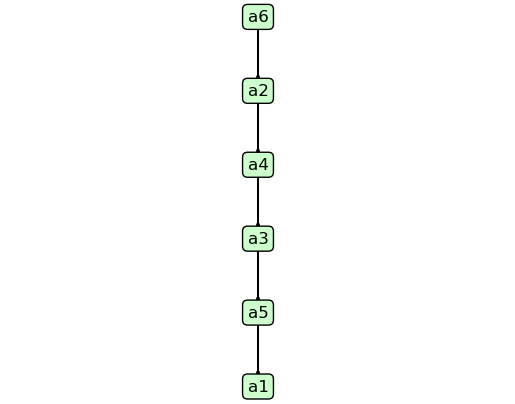

In [14]:
# Call TOPSIS
relative_closeness = algorithm.topsis_method(raw_data, weights, criteria_types, graph = True, verbose = True)